In [40]:
!rm -rf data/
!git clone https://github.com/cse151a-nba-project/data.git

'rm' is not recognized as an internal or external command,
operable program or batch file.
Cloning into 'data'...


In [13]:
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Finish major preprocessing

Nearly all of our preprocessing was done in the previous milestone. In this milestone, we'll go ahead and take advanced player data from teams and try to predict their win percentage. Below is code from the previous milestone that helps with our data retrieval and preprocessing.

In [14]:
TOP_X_PLAYERS = 8
INPUT_STATS = ['per', 'ws_48', 'usg_percent', 'bpm', 'vorp']
INPUT_FEATURE_COUNT = TOP_X_PLAYERS * len(INPUT_STATS)
START_YEAR = 1990
END_YEAR = 2023

"""
Extract raw stats of top players in a given year (for either a specific team or all teams).
Uses Advanced.csv file and extracts INPUT_STATS fields.

Output: A tuple containing two elements:
corresp_team_win: A list of (actual) win percentages for the teams included in the analysis.
  (y value that we're trying to predict with our models)
top_list_stats: A NumPy array containing the raw numerical values for the advanced statistics for the top 8 players
of the teams included in the analysis, optionally reshaped based on the INPUT_FEATURE_COUNT for model training.
Without reshaping, it is in the shape of (total teams in year, TOP_X_PLAYERS, INPUT_STATS). Reshaped is (year, INPUT_FEATURE_COUNT).
  (x value that we're using to predict y in our models)
"""
def top_from_team(year, reshape=True, input_team=None):
  advanced_player_data = pd.read_csv("data/Advanced.csv")
  team_data = pd.read_csv("data/Team Summaries.csv")
  team_data = team_data[team_data['season'] == year]
  player_data = pd.read_csv("data/Player Per Game.csv")
  player_data = player_data[player_data['season'] == year]
  top = player_data.sort_values(['tm', 'mp_per_game'], ascending=[True, False])
  teams = top['tm'].unique()

  if (input_team is not None):
    teams = teams[teams == input_team]
    top = top[top['tm'] == input_team]
  else:
    teams = teams[teams != 'TOT']
    top = top[top['tm'] != 'TOT']

  # make a list of the top 8 players from each team, separated by team name
  top_list = []
  top_list_stats = []
  corresp_team_win = []
  i = 0
  for team in teams:

      # get top 8 players
      top_list.append(top[top['tm'] == team].head(TOP_X_PLAYERS)[['seas_id', 'player_id', 'player', 'pos', 'tm', 'mp_per_game']])

      top_list_stats.append(None)

      # calculate win percentage
      temp_team_stats = team_data[team_data['abbreviation'] == team]
      corresp_team_win.append(100 * float(temp_team_stats['w']) / (float(temp_team_stats['w']) + float(temp_team_stats['l'])))

      # do an advanced stats look up for players
      for index, player in top_list[i].iterrows():
        indiv_player_stats = advanced_player_data[advanced_player_data['seas_id'] == player['seas_id']][INPUT_STATS].to_numpy()
        if (top_list_stats[i] is None):
          top_list_stats[i] = indiv_player_stats
        else:
          top_list_stats[i] = np.concatenate((top_list_stats[i], indiv_player_stats))

        # add mp_per_game
        # top_list_stats[i][player['seas_id']]['mp_per_game'] = player['mp_per_game']
      i = i + 1
  top_list_stats = np.array(top_list_stats)
  if (reshape):
    top_list_stats = top_list_stats.reshape(-1, INPUT_FEATURE_COUNT)
  return corresp_team_win, top_list_stats

In [15]:
all_data_y = None
all_data_x = None

# combining data
for i in range(START_YEAR, END_YEAR + 1):
  # win perc is y, top team players stats is x
  data_y, data_x = top_from_team(i)
  # don't concatenate if empty
  if (all_data_y is None):
    all_data_y = data_y
    all_data_x = data_x
    continue
  all_data_y = np.concatenate((all_data_y, data_y))
  all_data_x = np.concatenate((all_data_x, data_x))

In [5]:
print(all_data_x.shape)
print(all_data_y.shape)

(993, 40)
(993,)


# 2. Train your first model

We decided to use LinearRegression to keep it simple and see how it would perform.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(all_data_x, all_data_y, test_size = 0.2, random_state=21)

regressor = LinearRegression().fit(X_train, y_train)

# 3. Evaluate your model compare training vs test error

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = regressor.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

Model Training MSE: 21.829770676150357
Model Training MAE (Mean Absolute Error): 3.6668298317069015
Model Training R^2 (Coeff of Deter.): 0.9101089445076146


In [205]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

Model Testing MSE: 24.089338248039507
Model Testing MAE (Mean Absolute Error): 3.8786683795508496
Model Testing R^2 (Coeff of Deter.): 0.8878729896447337


## Visualization: Team Win Percentage (Predicted vs. Acutal)

MSE: 25.54138282576276


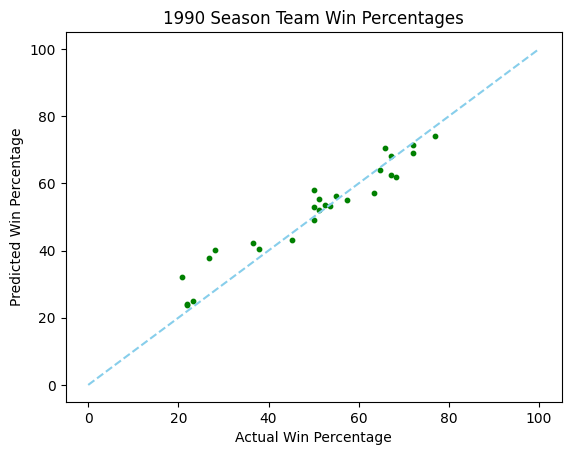

MSE: 17.969359047941218


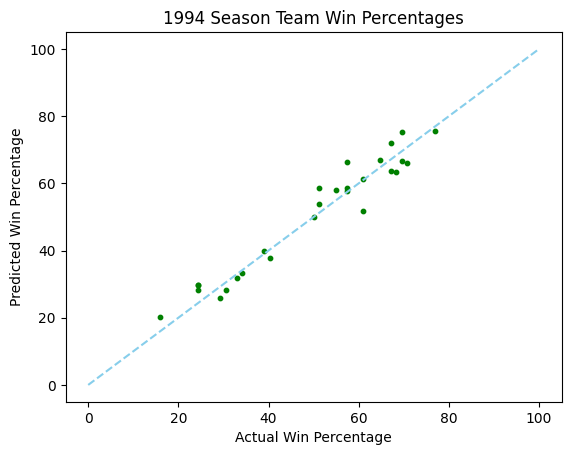

MSE: 14.585765325623948


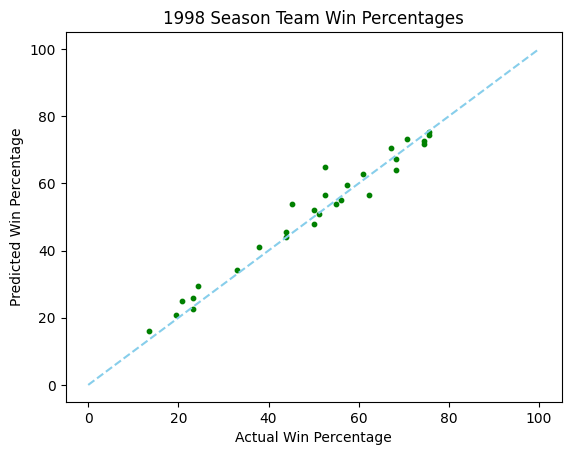

MSE: 19.576253257274843


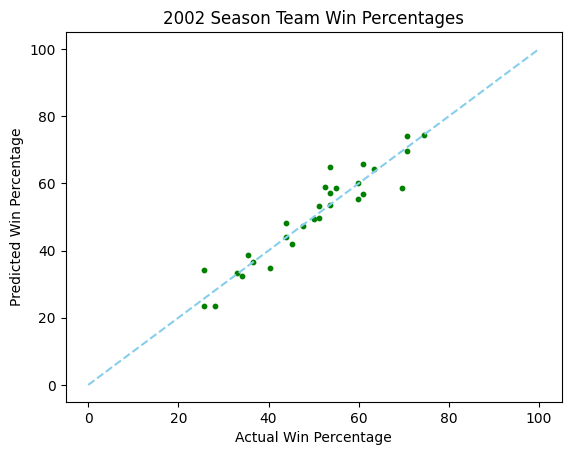

MSE: 23.28337086068974


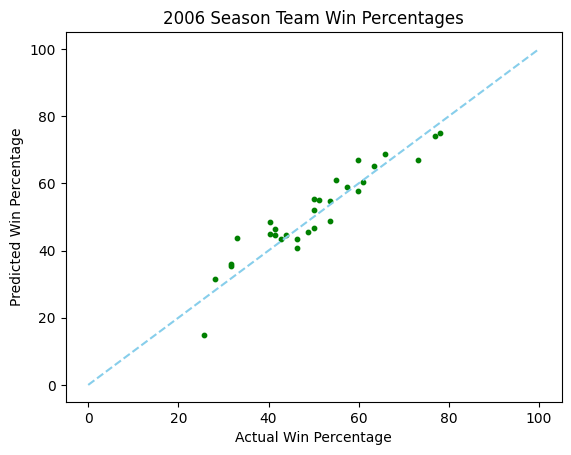

MSE: 15.196933979614808


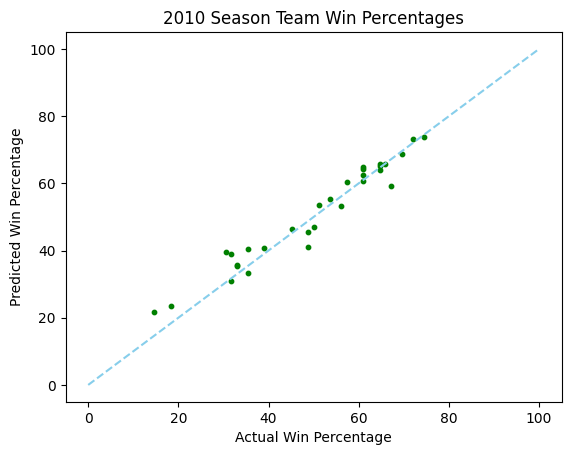

MSE: 30.297418205714173


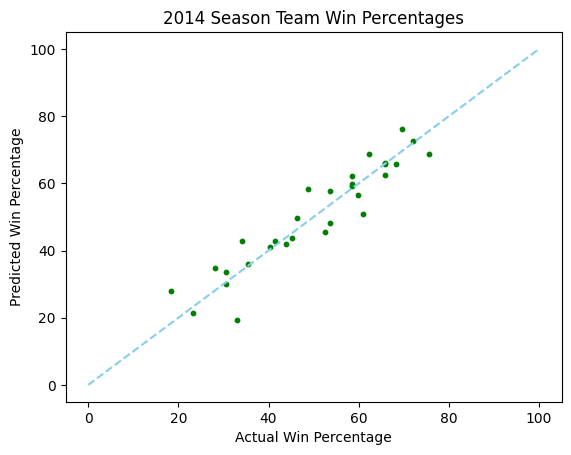

MSE: 27.276238651432983


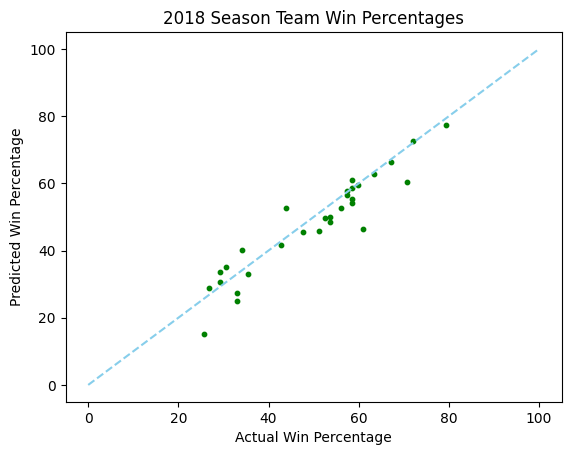

MSE: 27.385716246887455


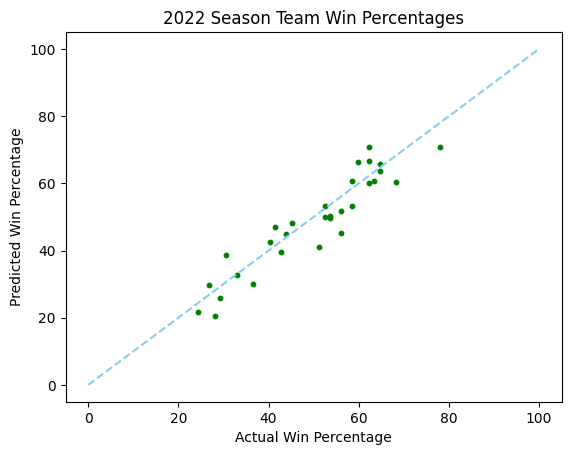

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_win_dist_predict_vs_actual(year):
  year_win, year_stats = top_from_team(year)
  year_predicted = regressor.predict(year_stats)
  print(f'MSE: {mean_squared_error(year_win, year_predicted)}')

  plt.figure(0)
  plt.scatter(year_win, year_predicted, color="green", s=10)
  identity_line = np.linspace(0,100)
  plt.plot(identity_line, identity_line, color="skyblue", linestyle="dashed")

  plt.xlabel('Actual Win Percentage')
  plt.ylabel('Predicted Win Percentage')
  plt.title(f'{year} Season Team Win Percentages')

  # Display the plot
  plt.show()

for i in range(START_YEAR, END_YEAR + 1, 4):
  plot_win_dist_predict_vs_actual(i)

## Visualization: Prediction Distributions and Team Percentage Residual Error 

1990 Actual vs. Predicted MSE: 25.54138282576276


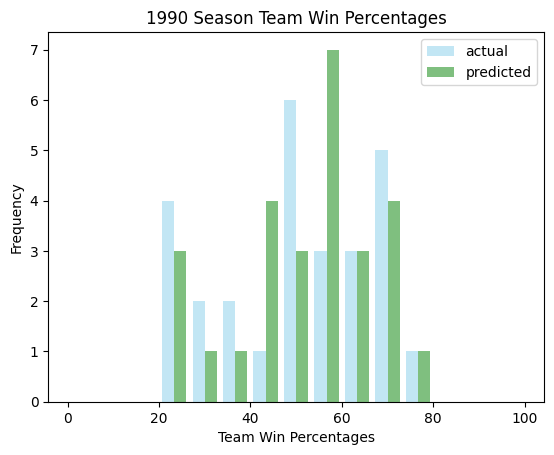

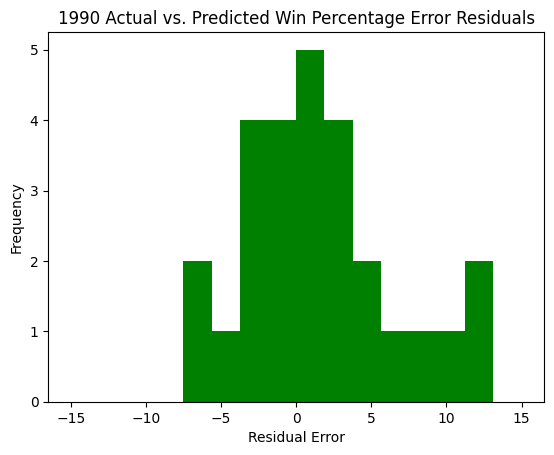

1994 Actual vs. Predicted MSE: 17.969359047941218


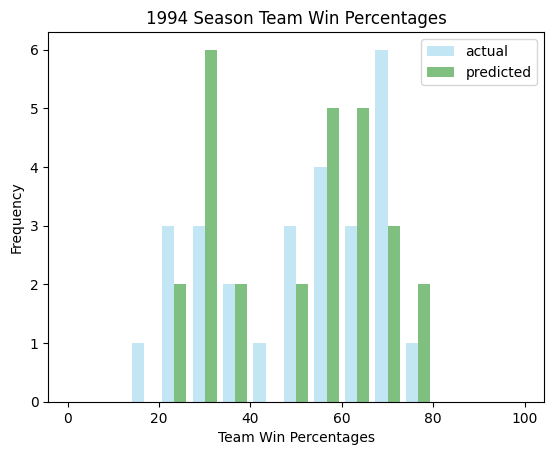

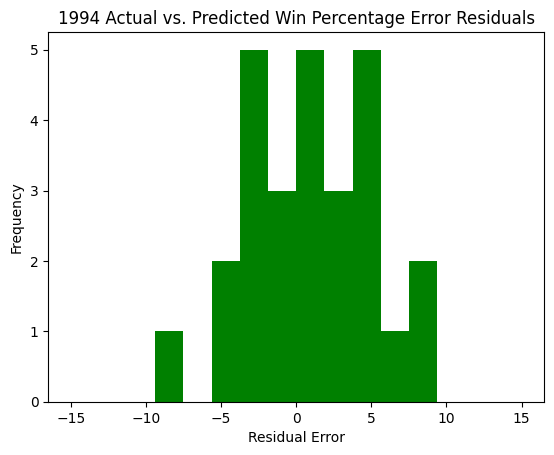

1998 Actual vs. Predicted MSE: 14.585765325623948


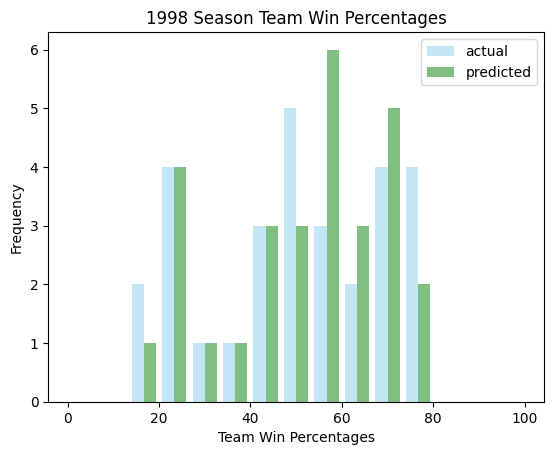

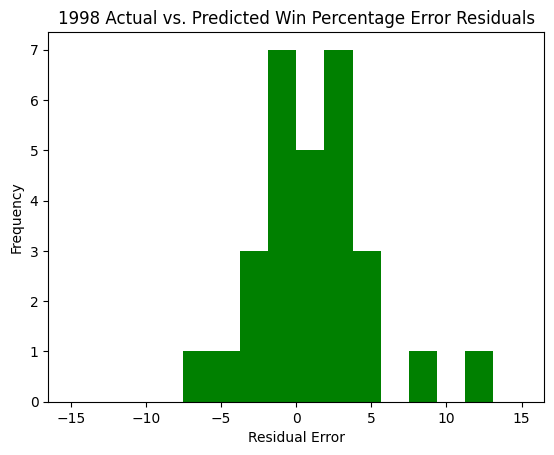

2002 Actual vs. Predicted MSE: 19.576253257274843


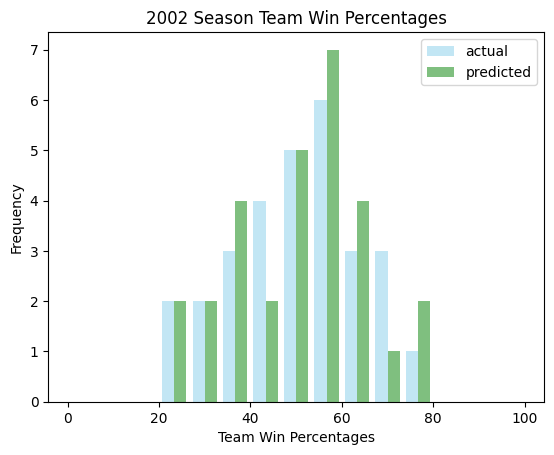

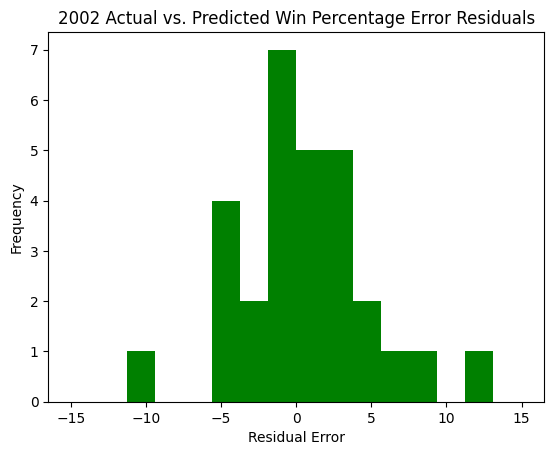

2006 Actual vs. Predicted MSE: 23.28337086068974


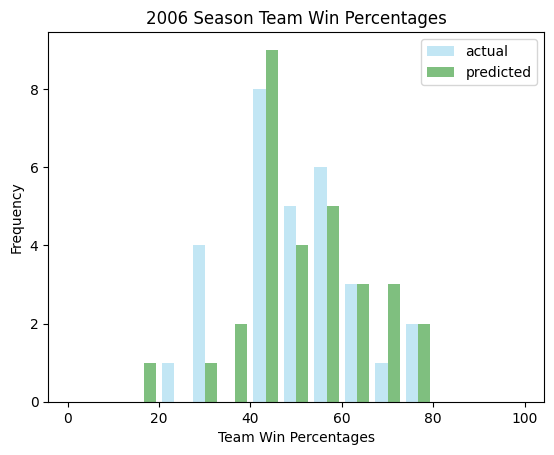

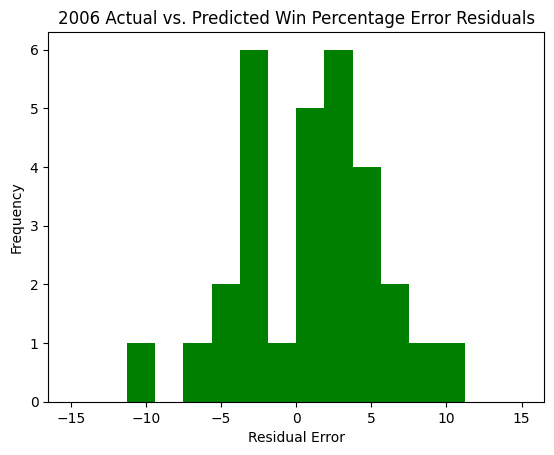

2010 Actual vs. Predicted MSE: 15.196933979614808


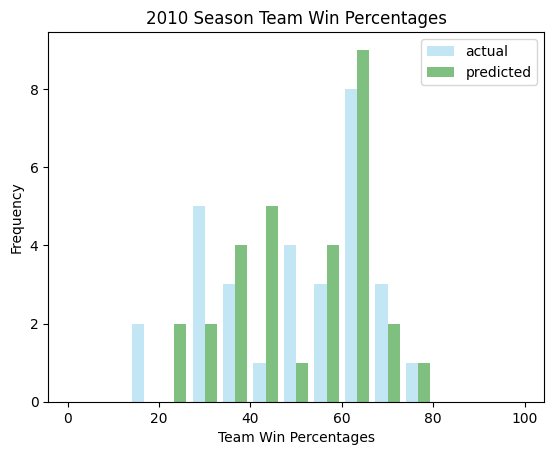

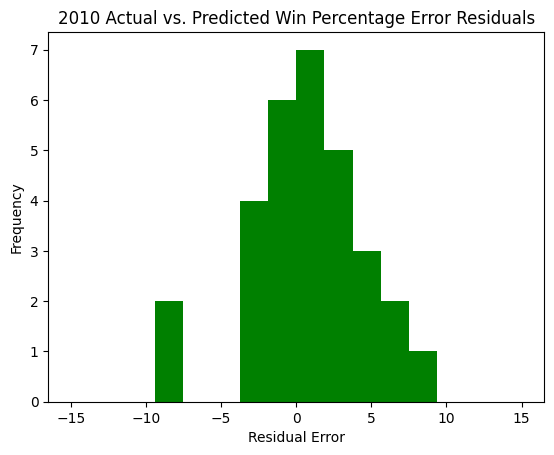

2014 Actual vs. Predicted MSE: 30.297418205714173


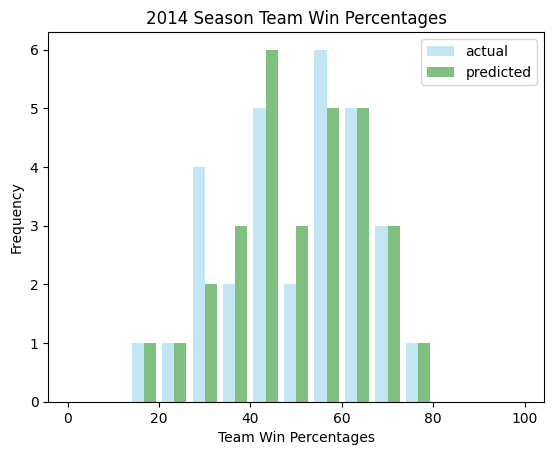

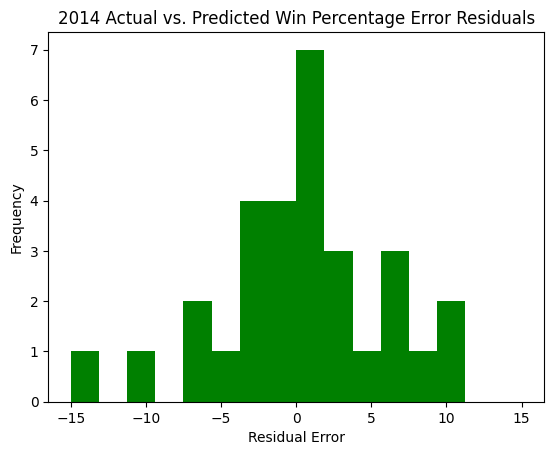

2018 Actual vs. Predicted MSE: 27.276238651432983


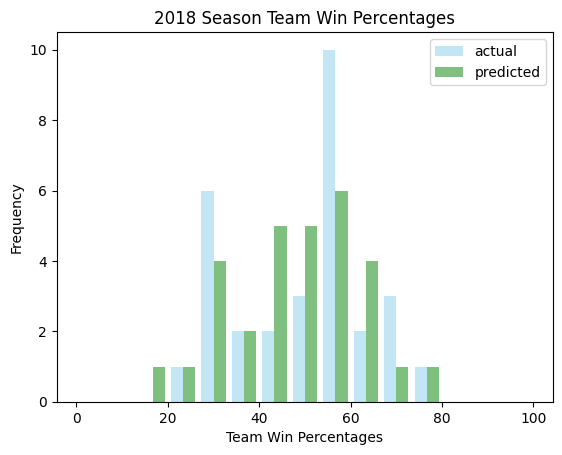

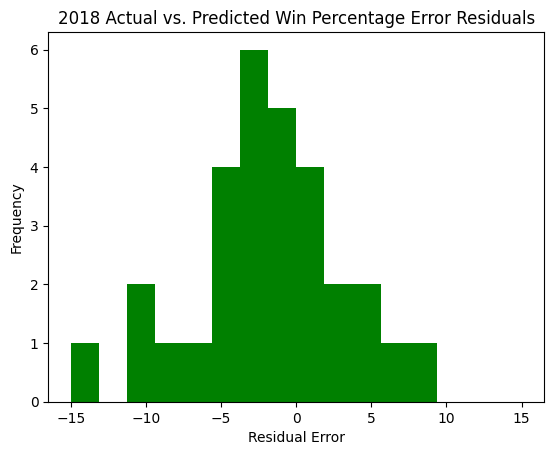

2022 Actual vs. Predicted MSE: 27.385716246887455


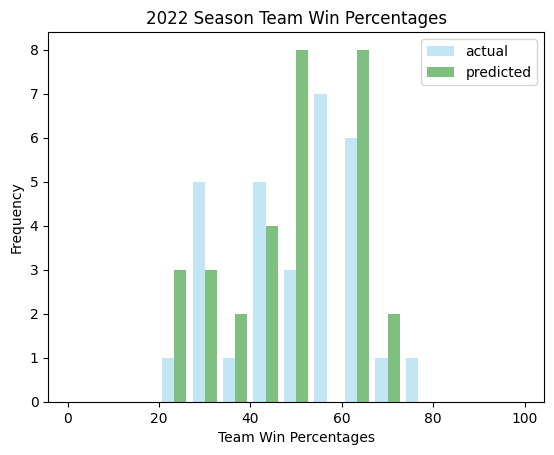

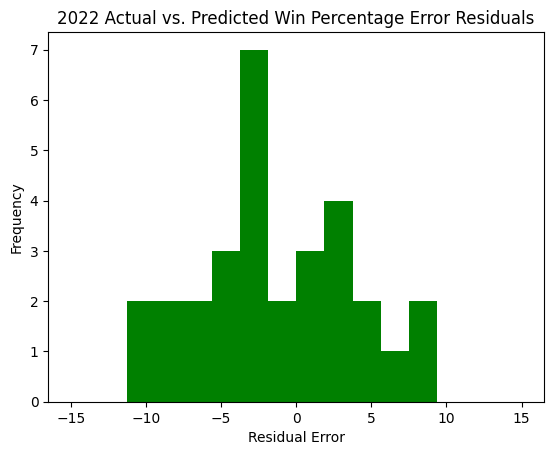

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_win_perc_residuals_predict_vs_actual(year):
  year_win, year_stats = top_from_team(year)
  year_predicted = regressor.predict(year_stats)
  # print(f'{year}\'s actual win percentages: {year_win}')
  # print(f'{year}\'s predicted win percentages: {year_predicted}')
  print(f'{year} Actual vs. Predicted MSE: {mean_squared_error(year_win, year_predicted)}')

  plt.figure(0)
  plt.hist([year_win, year_predicted], range=[0, 100], alpha=0.5, bins=15, color = ["skyblue", "green"], label=['actual', 'predicted'])

  plt.legend(loc='upper right')
  plt.xlabel('Team Win Percentages')
  plt.ylabel('Frequency')
  plt.title(f'{year} Season Team Win Percentages')

  plt.figure(1)
  plt.hist(np.array(year_predicted) - np.array(year_win),color="green",bins=16, range=[-15, 15])
  plt.xlabel('Residual Error')
  plt.ylabel('Frequency')
  plt.title(f'{year} Actual vs. Predicted Win Percentage Error Residuals')
  plt.show()

for i in range(START_YEAR, END_YEAR + 1, 4):
  plot_win_perc_residuals_predict_vs_actual(i)

# Fun Exploratory: Predicting This Year's Teams

In [12]:
team_abbrev_file = pd.read_csv("data/Team Abbrev.csv")
team_abbrev_file = team_abbrev_file[team_abbrev_file['season'] == 2024]
team_abbrev = team_abbrev_file[['team', 'abbreviation']].to_numpy()

for i in range(team_abbrev.shape[0]):
  team_win_perc_actual, team_stats = top_from_team(2024, True, team_abbrev[i][1])
  team_win_perc_predicted = regressor.predict(team_stats)

  print(f'{team_abbrev[i][0]} Actual win percentage: {team_win_perc_actual[0]}. Predicted win percentage: {team_win_perc_predicted[0]} [{team_win_perc_predicted[0] - team_win_perc_actual[0]}]')

Atlanta Hawks Actual win percentage: 43.63636363636363. Predicted win percentage: 39.81292697852951 [-3.8234366578341223]
Boston Celtics Actual win percentage: 78.18181818181819. Predicted win percentage: 67.4847522268453 [-10.697065954972885]
Brooklyn Nets Actual win percentage: 38.888888888888886. Predicted win percentage: 36.976152149769824 [-1.9127367391190617]
Charlotte Hornets Actual win percentage: 24.074074074074073. Predicted win percentage: 22.70130339553963 [-1.3727706785344438]
Chicago Bulls Actual win percentage: 47.27272727272727. Predicted win percentage: 42.890230025366996 [-4.382497247360277]
Cleveland Cavaliers Actual win percentage: 67.9245283018868. Predicted win percentage: 59.05432513098243 [-8.870203170904368]
Dallas Mavericks Actual win percentage: 58.18181818181818. Predicted win percentage: 45.038084992363096 [-13.143733189455084]
Denver Nuggets Actual win percentage: 65.45454545454545. Predicted win percentage: 55.26978625928605 [-10.184759195259403]
Detroit 

#4. Where does your model fit in the fitting graph.

In the fitting graph, we still have quite a bit of error (our MSE is > 20 for both testing and training) where a good value will likely be around 1-5 (an approximation, we're not exactly sure how good we can get it, but we predict it can be improved). To interpret this MSE, an error of 9 would translate to an average difference of 3% between predicted winning percentage and actual, which means 2-3 more / less games won.  Based on the test and training errors themselves, we can't differentiate if we're underfitting or having a good fit, because they're quite similar, with the test error only being slightly greater than the training error (~24.1 vs ~21.8). We believe the model is underfitting and has a high error and can be improved because we are only using a linear regression model right now - at least polynomial regression should decrease error and more complex modeling with SVMs and DNNs could also reach a better fit (move our vertical dashed red line to the right without reaching the overfitting region).

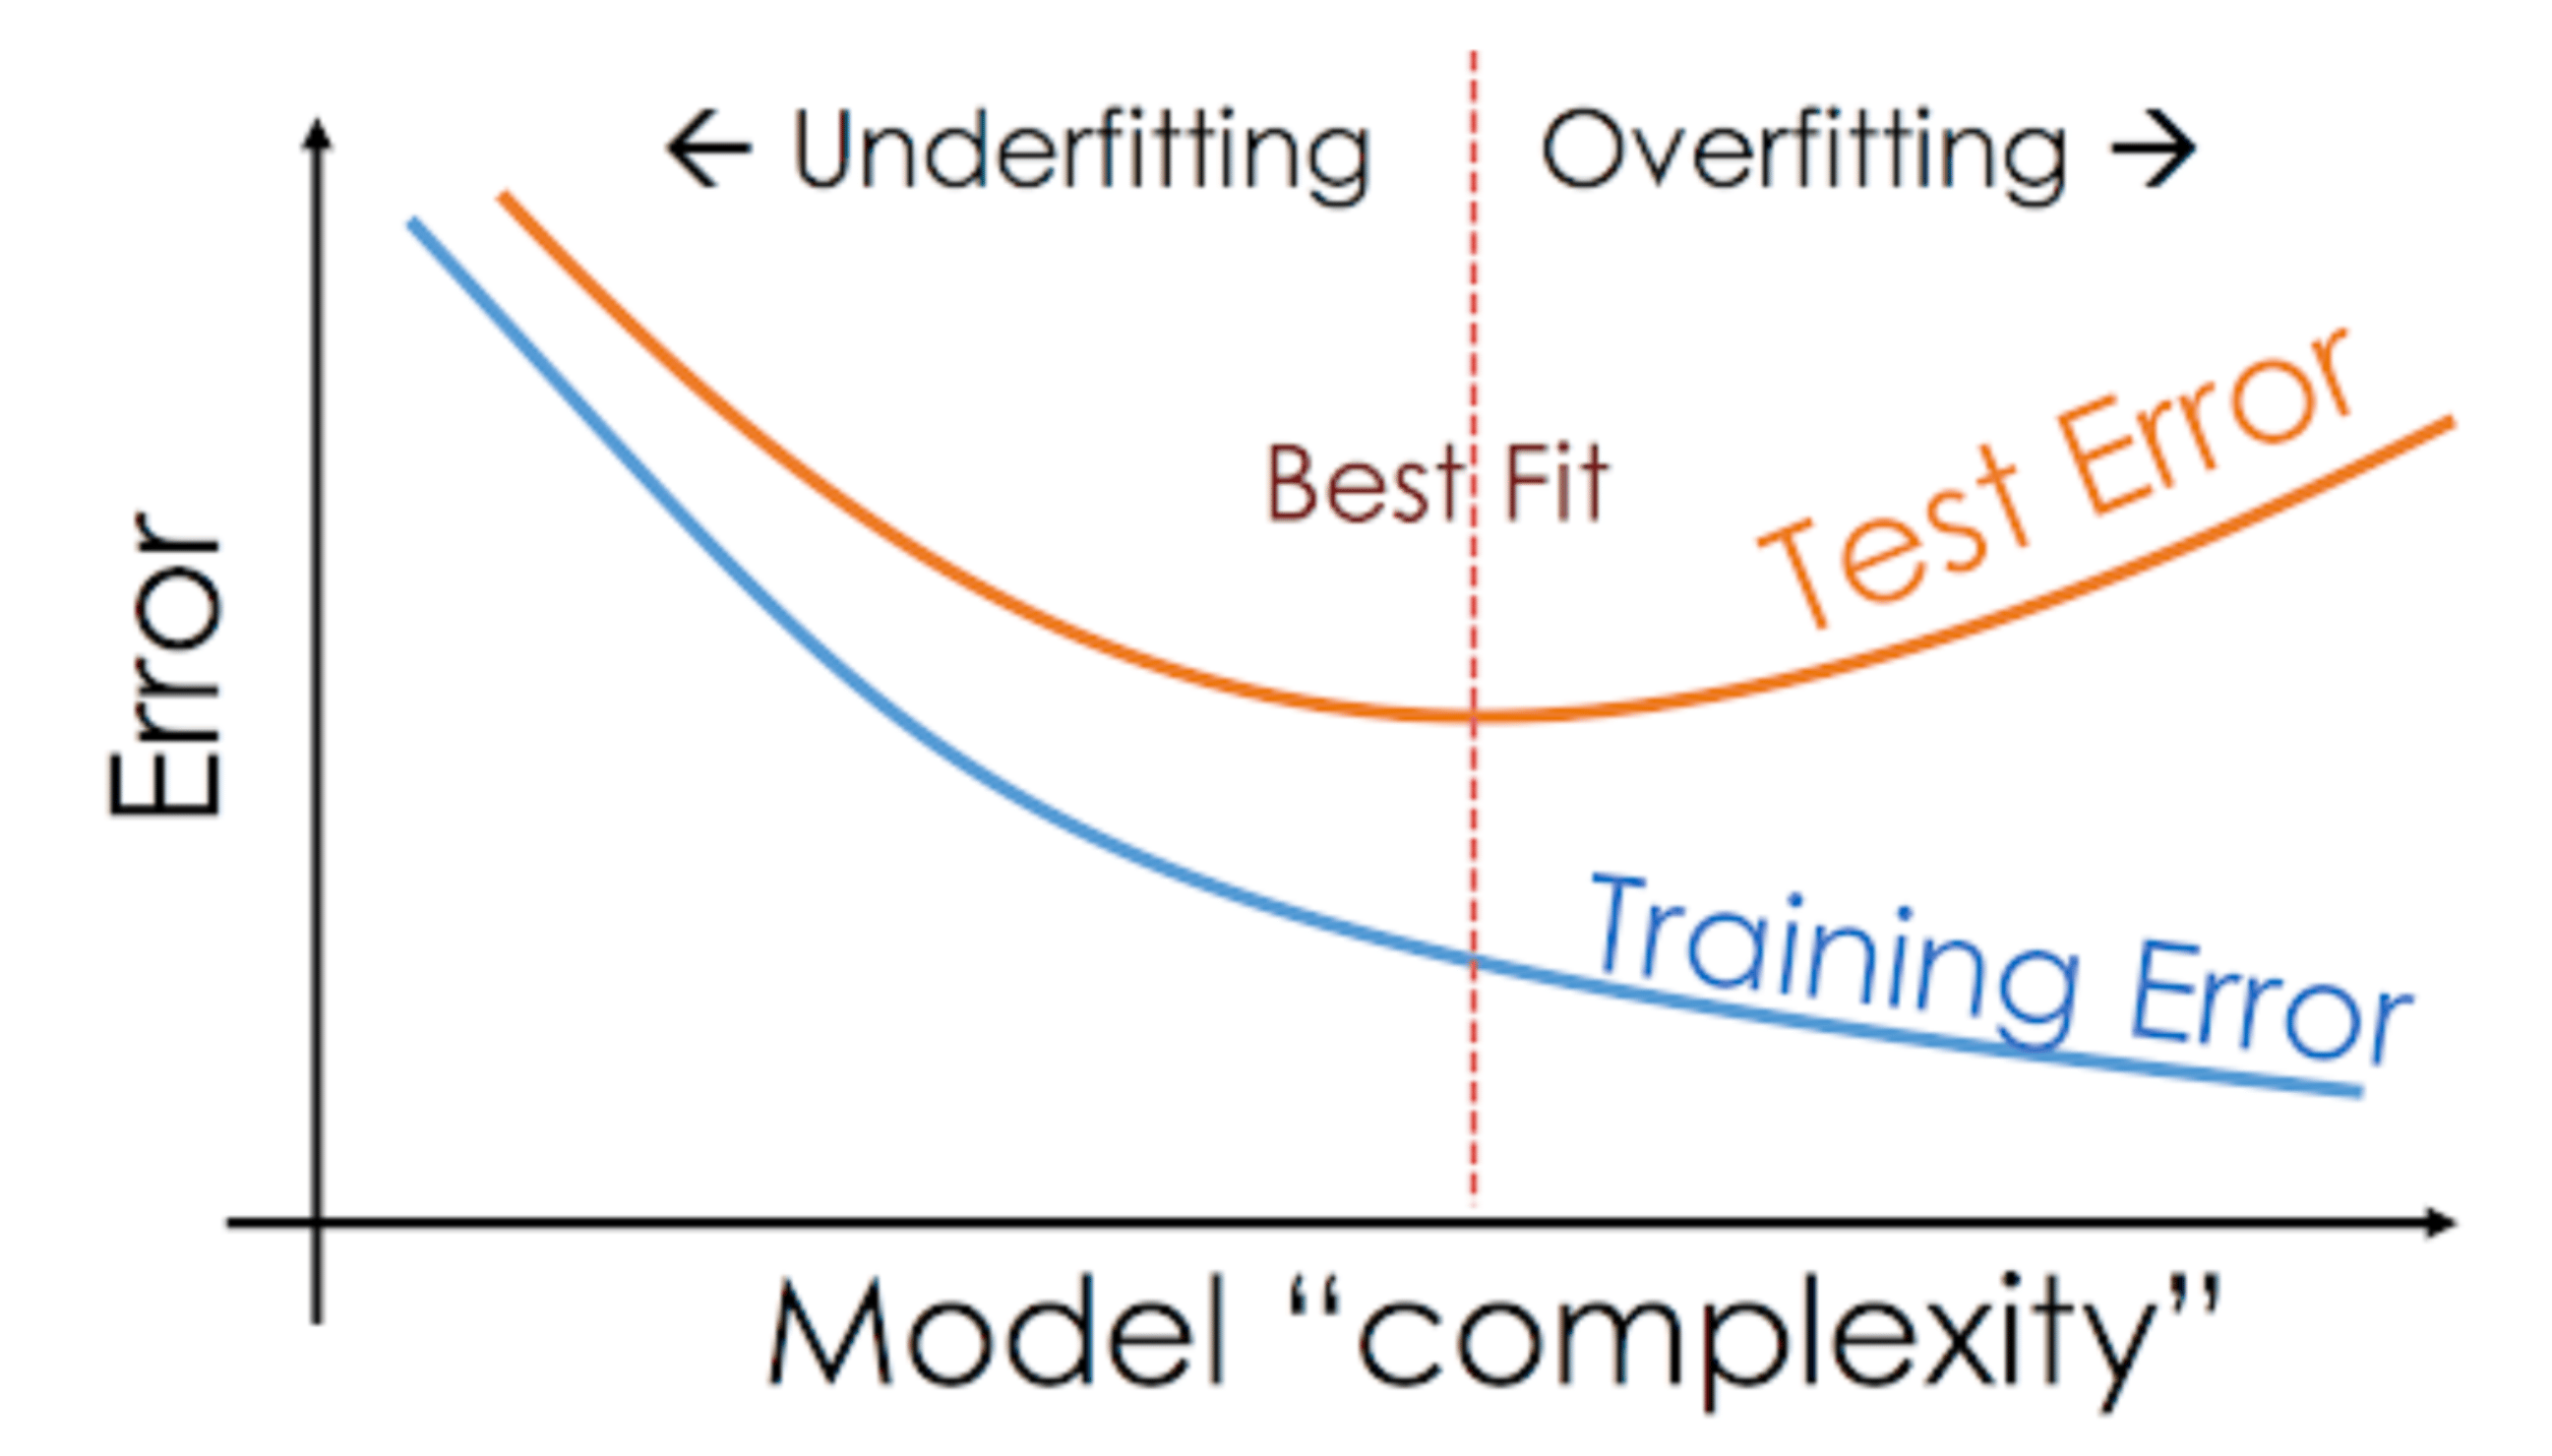

#5. What are the next 2 models you are thinking of and why?



Based on the analysis of your current model's performance with linear regression, which indicates underfitting given the high mean squared error (MSE) rates for both testing and training, we are considering the following Polynomial Regression and Deep Neural Network (DNN) Regression as the next two models to potentially improve the predictive accuracy of our model:

We want to experiment with polynomial regression next because it can model relationships between variables that are not linear, capturing more complex patterns in the dataset. Given the nature of sports statistics and team performance metrics, the relationship between the input features (advanced player statistics) and the output (team win percentages) might not be linear but could have a polynomial relationship. Polynomial regression can provide a better fit to the dataset by adding degrees of freedom through higher-order terms, potentially reducing the underfitting observed with the linear regression model.

Planned Strategy:
We plan to experiment with different polynomial degrees to find the optimal level of complexity that improves the model's performance without leading to overfitting. This involves transforming our input features into polynomial features and then applying linear regression to these transformed features.
Cross-validation will be used to evaluate the model's performance and prevent overfitting by selecting the degree of the polynomial that provides the best generalization to unseen data.

Deep Neural Network (DNN) Regression
Because Deep Neural Networks are capable of learning very complex patterns in large datasets, we believe it is suitable for our problem where traditional linear models fail to capture the underlying relationships. DNN regression can model intricate interactions between player statistics and their impact on team success rates through its multiple hidden layers and non-linear activation functions. This flexibility allows DNNs to potentially offer significant improvements over simpler models by accurately capturing the non-linear and complex relationships in our dataset.

Planned Strategy:
We aim to design a DNN with several hidden layers and neurons, experimenting with different architectures to find the most effective configuration for our dataset. Regularization techniques (like dropout and L2 regularization) and optimization algorithms will be also used to enhance learning and prevent overfitting.
Feature scaling and normalization will be crucial preprocessing steps
(that we've done in milestone 2) to ensure that the DNN model trains efficiently.
We will also use a portion of the dataset for validation during training to monitor for overfitting and adjust the model's parameters accordingly.

#Conclusion section: What is the conclusion of your 1st model? What can be done to possibly improve it?

Our initial approach to predicting team win percentages based on advanced player statistics utilized a linear regression model. The analysis of this model's performance revealed a higher than desired mean squared error (MSE) for both training and testing datasets, indicating that our model is not fitting the data as well as we hoped. With training and testing MSE values greater than 20, where a more acceptable range would likely be around 1-5, it's clear that our model is underperforming. The similarity of the test and training errors suggests that our model is underfitting, rather than perfectly fitting or overfitting the data.

Possible Improvements
To address the underfitting and improve our model's performance, we propose several strategies:

Feature Engineering and Selection:
Re-evaluate the input features used in the model. Advanced player statistics are complex and can have nonlinear relationships with team success. Exploring additional or different metrics, as well as interactions between features, might uncover more relevant predictors.
Polynomial features can be introduced to model nonlinear relationships without immediately moving to more complex models like DNNs.

Model Complexity:
Increase the complexity of our predictive model to better capture the nuances in the data. This involves transitioning from a simple linear regression to models capable of learning nonlinear patterns, such as Polynomial Regression and Deep Neural Networks (DNNs), as discussed earlier.

Cross-Validation and Hyperparameter Tuning:
Use cross-validation techniques to more accurately evaluate model performance and prevent overfitting. This approach will be particularly important when experimenting with polynomial regression degrees and DNN architectures.
Hyperparameter tuning can optimize the model's performance, especially for DNNs, where parameters such as the number of layers, number of neurons, learning rate, and regularization terms play significant roles.

Regularization Techniques:
Apply regularization techniques (like Lasso, Ridge, or ElasticNet for polynomial regression, and dropout or batch normalization for DNNs) to reduce the risk of overfitting by penalizing overly complex models.